----
# 1. 데이터 불러오기 및 전처리
---

In [1]:
import pandas as pd
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [3]:
print('user_id:',ratings['user_id'].nunique())
print('movie_id:',ratings['movie_id'].nunique())
print('rating kind:',ratings['rating'].unique())
print('timestamp:',ratings['timestamp'].nunique())

user_id: 6039
movie_id: 3628
rating kind: [5 3 4]
timestamp: 412911


- 평점이 3점 이상인 데이터만 남았다.  
- user_id가 1개 줄어든 것을 보니... 한 유저는 3점 이하의 점수만 준듯 하다...

In [4]:
# rating 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'rating':'counts'}, inplace=True)

In [5]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

- 사용할 컬럼만 추출 

In [6]:
ratings = ratings[['user_id','movie_id','counts']]

- 영화 제목을 보기 위해 메타 데이터를 읽어오기

In [7]:
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head(15)

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


- 데이터 프레임 조인 

In [9]:
ratings_movies = ratings.merge(movies, on='movie_id', how='left')

---
# 2.데이터 탐색
---

In [10]:
print(len(ratings_movies))
ratings_movies.head()

836478


,user_id,movie_id,counts,title,genre
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,My Fair Lady (1964),Musical|Romance
3,1,3408,4,Erin Brockovich (2000),Drama
4,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [11]:
ratings_movies.isnull().sum()

user_id     0
movie_id    0
counts      0
title       0
genre       0
dtype: int64

- 훈련시 사용할 데이터 추출

In [12]:
traing_data = ratings_movies[['user_id','title','counts']] #훈련시 사용하게 될 데이터 컬럼을 추출해 놓음.

---
### 2-1 데이터 분석
---

- 유저 데이터 수

In [13]:
num_movie = ratings_movies['movie_id'].nunique()
num_movie

3628

- 영화 데이터 수 

In [14]:
num_user = ratings_movies['user_id'].nunique()
num_user

6039

In [15]:
movie_counts = ratings_movies.groupby('movie_id')['counts'].count()
movie_counts_top30 = movie_counts.sort_values(ascending=False).head(30)
movie_counts_top30.head()

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
Name: counts, dtype: int64

In [16]:
df = pd.DataFrame(data = movie_counts_top30
                ,index = movie_counts_top30.index)

- 상위 30등 영화 데이터 

In [17]:
movie_counts_top30 = df.merge(movies, on='movie_id', how='left')
movie_counts_top30

,movie_id,counts,title,genre
0,2858,3211,American Beauty (1999),Comedy|Drama
1,260,2910,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
2,1196,2885,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
3,1210,2716,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
4,2028,2561,Saving Private Ryan (1998),Action|Drama|War
5,589,2509,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
6,593,2498,"Silence of the Lambs, The (1991)",Drama|Thriller
7,1198,2473,Raiders of the Lost Ark (1981),Action|Adventure
8,1270,2460,Back to the Future (1985),Comedy|Sci-Fi
9,2571,2434,"Matrix, The (1999)",Action|Sci-Fi|Thriller


---
# 3. 선호하는 영화 고르기
---

In [18]:
traing_data['title'] = traing_data['title'].str.lower() # 검색을 쉽게하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
traing_data.head(10)

/tmp/ipykernel_128/1752571730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traing_data['title'] = traing_data['title'].str.lower() # 검색을 쉽게하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.


,user_id,title,counts
0,1,one flew over the cuckoo's nest (1975),5
1,1,james and the giant peach (1996),3
2,1,my fair lady (1964),3
3,1,erin brockovich (2000),4
4,1,"bug's life, a (1998)",5
5,1,"princess bride, the (1987)",3
6,1,ben-hur (1959),5
7,1,"christmas story, a (1983)",5
8,1,snow white and the seven dwarfs (1937),4
9,1,"wizard of oz, the (1939)",4


- 좋아하는 영화 5개 고르기
- 정확한 타이틀 명을 알기 위해 str.contains을 통해 정확한 명을 찾아주겠다.
- 맨인블랙

In [19]:
traing_data[traing_data['title'].str.contains('men in black')]

,user_id,title,counts
185,3,men in black (1997),3
321,5,men in black (1997),4
470,7,men in black (1997),4
563,8,men in black (1997),4
1032,10,men in black (1997),5
...,...,...,...
834398,6025,men in black (1997),3
834565,6026,men in black (1997),3
834622,6027,men in black (1997),4
834969,6033,men in black (1997),5


- 백투더퓨쳐
- 물론 영화는 안봤으나 유명하다기에 선택하겠다.

In [20]:
traing_data[traing_data['title'].str.contains('back to the ')]

,user_id,title,counts
22,1,back to the future (1985),5
204,3,back to the future (1985),3
462,7,back to the future (1985),4
780,10,back to the future (1985),4
1010,10,back to the future part ii (1989),4
...,...,...,...
835851,6036,back to the future part iii (1990),3
836005,6037,back to the future (1985),3
836167,6039,back to the future (1985),4
836368,6040,back to the future (1985),3


- 이번에 재개봉한 톰 크루즈 형의 탑건

In [21]:
traing_data[traing_data['title'].str.contains('top gun')]

,user_id,title,counts
378,6,top gun (1986),4
919,10,top gun (1986),4
3028,26,top gun (1986),4
3358,29,top gun (1986),3
3770,33,top gun (1986),4
...,...,...,...
832534,6011,top gun (1986),5
833115,6016,top gun (1986),3
833972,6021,top gun (1986),4
834653,6028,top gun (1986),5


- 어렴풋이 본 기억이 있는 바람과 함께 사라지다

In [22]:
traing_data[traing_data['title'].str.contains('with the wind')]

,user_id,title,counts
147,2,gone with the wind (1939),5
440,6,gone with the wind (1939),4
700,9,gone with the wind (1939),3
889,10,gone with the wind (1939),5
1839,18,gone with the wind (1939),5
...,...,...,...
833961,6021,gone with the wind (1939),4
834721,6030,gone with the wind (1939),3
835226,6036,gone with the wind (1939),5
836066,6038,gone with the wind (1939),3


- 고전 명작에 매번 뽑히는 쇼생크 탈출 

In [23]:
traing_data[traing_data['title'].str.contains('shawshank')]

,user_id,title,counts
162,2,"shawshank redemption, the (1994)",5
302,5,"shawshank redemption, the (1994)",3
659,9,"shawshank redemption, the (1994)",5
800,10,"shawshank redemption, the (1994)",4
1119,11,"shawshank redemption, the (1994)",5
...,...,...,...
834569,6026,"shawshank redemption, the (1994)",4
835077,6035,"shawshank redemption, the (1994)",5
835469,6036,"shawshank redemption, the (1994)",5
835955,6037,"shawshank redemption, the (1994)",5


In [24]:
#정보를 추가히기 전에 컬럼 타입이 무엇인지 확인
traing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 836477
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  836478 non-null  int64 
 1   title    836478 non-null  object
 2   counts   836478 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 25.5+ MB


In [25]:
# 내가 좋아하시는 영화의 데이터로 바꿔서 추가
favorite_movie = ['men in black (1997)' , 'back to the future (1985)' ,'top gun (1986)' ,'gone with the wind (1939)' ,'shawshank redemption, the (1994)']

# '6041'이라는 user_id가 위 영화를 6회씩 봤다고 가정
my_playlist = pd.DataFrame({'user_id': [6041]*5, 'title': favorite_movie, 'counts':[6]*5})
my_playlist

,user_id,title,counts
0,6041,men in black (1997),6
1,6041,back to the future (1985),6
2,6041,top gun (1986),6
3,6041,gone with the wind (1939),6
4,6041,"shawshank redemption, the (1994)",6


In [26]:
# user_id에 '6041'이라는 데이터가 없다면
# 위에 임의로 만든 favorite_movie 데이터를 추가해 줍니다. 
if not traing_data.isin({'user_id':['6041']})['user_id'].any(): 
    traing_data = traing_data.append(my_playlist)                      

traing_data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,title,counts
836473,6040,platoon (1986),3
836474,6040,"crying game, the (1992)",5
836475,6040,welcome to the dollhouse (1995),5
836476,6040,sophie's choice (1982),4
836477,6040,e.t. the extra-terrestrial (1982),4
0,6041,men in black (1997),6
1,6041,back to the future (1985),6
2,6041,top gun (1986),6
3,6041,gone with the wind (1939),6
4,6041,"shawshank redemption, the (1994)",6


In [27]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = traing_data['user_id'].unique()
movie_unique = traing_data['title'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)} #user_id인 v는 index가 되었고, 0부터 시작하는 index인 k는 값이 됨. 
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [28]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx[6041])    # 6040명의 유저 중 마지막으로 추가된 유저이니 6039가 나와야 합니다. 
print(movie_to_idx["bug's life, a (1998)"])

6039
4


In [29]:
# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = traing_data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(traing_data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    traing_data['user_id'] = temp_user_data   # ratings['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# movie_to_idx 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = traing_data['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(traing_data):
    print('movie column indexing OK!!')
    traing_data['title'] = temp_movie_data
else:
    print('movie column indexing Fail!!')

traing_data

user_id column indexing OK!!
movie column indexing OK!!


,user_id,title,counts
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5
...,...,...,...
0,6039,175,6
1,6039,22,6
2,6039,326,6
3,6039,143,6


---
# 4. CSR matrix 직접 만들기 
---

In [30]:
traing_data.head()

,user_id,title,counts
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [31]:
from scipy.sparse import csr_matrix

num_user = traing_data['user_id'].nunique()
num_movie = traing_data['title'].nunique()

csr_data = csr_matrix((traing_data.counts, (traing_data.user_id, traing_data.title)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

---
# 5. ALS Model 만들기
---

 - factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
 - regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
 - use_gpu : GPU를 사용할 것인지
 - iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지



In [32]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'


als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [33]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T 
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [34]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [35]:
kk, top_gun = user_to_idx[6041], movie_to_idx["top gun (1986)"]
kk_vector, top_gun_vector = als_model.user_factors[kk], als_model.item_factors[top_gun]

In [36]:
kk_vector

array([-4.59280998e-01, -1.34557104e+00,  4.66850191e-01, -5.10401800e-02,
       -6.73992857e-02,  6.34537041e-01,  9.20936704e-01,  8.59898329e-01,
       -3.41756791e-01,  1.17870606e-01, -5.61424136e-01,  1.64191043e+00,
        4.58225369e-01, -8.45909193e-02,  1.32495994e-02,  3.24258387e-01,
        1.50212878e-02, -4.06438828e-01,  3.37756276e-01, -1.05467331e+00,
       -3.91899019e-01, -6.94152340e-02,  1.00441408e+00, -4.20442045e-01,
        6.32648647e-01,  8.47821414e-01,  2.61087418e-01,  1.25561068e-02,
       -8.27234566e-01, -9.63889435e-03, -3.73948902e-01,  5.95704436e-01,
       -3.14721823e-01, -4.53039646e-01, -5.46343684e-01,  2.41568044e-01,
       -2.84899801e-01, -8.72502476e-02, -3.23141068e-01, -3.15590873e-02,
       -4.58679259e-01,  5.27792275e-01,  4.53111112e-01, -2.50370335e-02,
        2.77999669e-01, -5.40991902e-01,  2.47844785e-01, -7.80286670e-01,
        9.17071998e-01,  4.08301026e-01, -4.34203207e-01,  6.00123107e-02,
        6.86186075e-01,  

In [37]:
top_gun_vector

array([ 1.15279632e-03, -3.43130529e-02, -7.71394698e-03,  4.76957262e-02,
       -4.56605852e-03,  2.13470608e-02,  3.20917182e-02,  1.80214886e-02,
       -7.41746090e-03,  1.03562260e-02,  6.04963908e-03,  1.60672441e-02,
        1.71596035e-02, -1.47364289e-02,  1.22807864e-02,  2.38386616e-02,
        1.57579668e-02,  1.42656278e-03, -2.41131568e-03,  1.32916318e-02,
        9.34576802e-03,  3.70621961e-03,  4.45721019e-03, -2.71844096e-04,
        2.31487937e-02,  3.78598683e-02,  1.90809406e-02,  5.86665049e-03,
        9.22197849e-03,  1.96452159e-02,  3.89184663e-03,  1.45075116e-02,
        3.57893133e-03,  3.60687482e-05,  1.17727695e-02,  1.70943663e-02,
       -7.12065212e-03,  2.37188525e-02, -1.11717992e-02,  4.89990786e-03,
        8.99666362e-03,  4.62937308e-03,  1.01265209e-02, -1.41082788e-02,
        3.06229945e-02, -8.20895191e-03,  2.74397992e-02,  3.76500711e-02,
        1.51119716e-02,  1.92585378e-03,  8.68088100e-03,  1.07066827e-02,
        1.77348964e-02,  

---
# 6. 결과값 보기
---

---
### 6-1. 훈련 모델의 예측 선호도 파악 
---

In [38]:
# 유저와 선택된 영화와 내적하는 코드
np.dot(kk_vector, top_gun_vector)

0.33012316

In [39]:
def prediction_score(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    movie_vector = als_model.item_factors[movie_id]
    return np.dot(kk_vector, movie_vector)

In [40]:
prediction_score('top gun (1986)')

0.33012316

In [41]:
prediction_score('back to the future (1985)')

0.5202953

In [42]:
prediction_score('gone with the wind (1939)')

0.5561979

In [43]:
prediction_score('shawshank redemption, the (1994)')

0.4871621

---
### 6-2. 비슷한 영화 추천 받기
---

In [44]:
favorite_movie = "shawshank redemption, the (1994)"
movie_id = movie_to_idx[favorite_movie]
similar_movies = als_model.similar_items(movie_id, N=15)
similar_movies

[(157, 0.99999994),
 (121, 0.79315525),
 (23, 0.7747502),
 (222, 0.73623675),
 (51, 0.67717946),
 (248, 0.6679753),
 (269, 0.6411027),
 (323, 0.51672226),
 (48, 0.4980822),
 (233, 0.48054984),
 (3517, 0.39576027),
 (3493, 0.3956594),
 (100, 0.39500067),
 (472, 0.38406563),
 (0, 0.3816774)]

In [45]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movies]

['shawshank redemption, the (1994)',
 'silence of the lambs, the (1991)',
 "schindler's list (1993)",
 'pulp fiction (1994)',
 'fargo (1996)',
 'good will hunting (1997)',
 'goodfellas (1990)',
 'dead man walking (1995)',
 'saving private ryan (1998)',
 'usual suspects, the (1995)',
 'paralyzing fear: the story of polio in america, a (1998)',
 'held up (2000)',
 'amadeus (1984)',
 'sling blade (1996)',
 "one flew over the cuckoo's nest (1975)"]

In [46]:
a = [i[1] for i in similar_movies]
a = a[1:]
a

[0.79315525,
 0.7747502,
 0.73623675,
 0.67717946,
 0.6679753,
 0.6411027,
 0.51672226,
 0.4980822,
 0.48054984,
 0.39576027,
 0.3956594,
 0.39500067,
 0.38406563,
 0.3816774]

In [47]:
def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movies = als_model.similar_items(movie_id)
    similar_movies = [idx_to_movie[i[0]] for i in similar_movies]
    return similar_movies


In [48]:
get_similar_movie('top gun (1986)')

['top gun (1986)',
 'romancing the stone (1984)',
 'dirty dancing (1987)',
 'indiana jones and the temple of doom (1984)',
 'jewel of the nile, the (1985)',
 'first blood (1982)',
 'red dawn (1984)',
 'presidio, the (1988)',
 'flashdance (1983)',
 'heartbreak ridge (1986)']

In [49]:
get_similar_movie('back to the future (1985)')

['back to the future (1985)',
 "ferris bueller's day off (1986)",
 'when harry met sally... (1989)',
 'ghostbusters (1984)',
 'e.t. the extra-terrestrial (1982)',
 'back to the future part ii (1989)',
 'fish called wanda, a (1988)',
 'big (1988)',
 'bull durham (1988)',
 'airplane! (1980)']

In [50]:
get_similar_movie('gone with the wind (1939)') 

['gone with the wind (1939)',
 'doctor zhivago (1965)',
 'casablanca (1942)',
 'grapes of wrath, the (1940)',
 'african queen, the (1951)',
 'graduate, the (1967)',
 'my fair lady (1964)',
 'from here to eternity (1953)',
 'sense and sensibility (1995)',
 'romeo and juliet (1968)']

In [51]:
get_similar_movie('shawshank redemption, the (1994)')

['shawshank redemption, the (1994)',
 'silence of the lambs, the (1991)',
 "schindler's list (1993)",
 'pulp fiction (1994)',
 'fargo (1996)',
 'good will hunting (1997)',
 'goodfellas (1990)',
 'dead man walking (1995)',
 'saving private ryan (1998)',
 'usual suspects, the (1995)']

---
### 6-3. 내가 좋아할 만한 영화 추천 받기
---

In [52]:
user = user_to_idx[6041]
# recommend에서는 user*item CSR Matrix를 받습니다.
movies_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movies_recommended

[(23, 0.5285251),
 (27, 0.41361856),
 (107, 0.38810623),
 (121, 0.3826729),
 (87, 0.37727588),
 (48, 0.37532243),
 (0, 0.34825504),
 (488, 0.32293522),
 (160, 0.30498812),
 (51, 0.296704),
 (5, 0.2902982),
 (26, 0.27732688),
 (138, 0.2744561),
 (150, 0.26751727),
 (361, 0.26606333),
 (92, 0.2517809),
 (110, 0.25133187),
 (99, 0.25094175),
 (161, 0.2492479),
 (325, 0.24773131)]

In [53]:
[idx_to_movie[i[0]] for i in movies_recommended]

["schindler's list (1993)",
 'titanic (1997)',
 'jurassic park (1993)',
 'silence of the lambs, the (1991)',
 'braveheart (1995)',
 'saving private ryan (1998)',
 "one flew over the cuckoo's nest (1975)",
 'when harry met sally... (1989)',
 'forrest gump (1994)',
 'fargo (1996)',
 'princess bride, the (1987)',
 'e.t. the extra-terrestrial (1982)',
 'true lies (1994)',
 'independence day (id4) (1996)',
 'casablanca (1942)',
 'terminator 2: judgment day (1991)',
 'groundhog day (1993)',
 'american beauty (1999)',
 'graduate, the (1967)',
 'romancing the stone (1984)']

---
### 6-4 모델이 추천한 영화가 실제로 선호하는지 계산하여 모델의 객관적 지표 도출
---

In [54]:
apollo = movie_to_idx['jurassic park (1993)']
explain = als_model.explain(user, csr_data, itemid=apollo)

In [55]:
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('men in black (1997)', 0.36267276784442826),
 ('back to the future (1985)', 0.04980423342896933),
 ('shawshank redemption, the (1994)', 0.018978326575934186),
 ('top gun (1986)', -0.01507857203732931),
 ('gone with the wind (1939)', -0.03101653977552586)]

In [56]:
def recomended_score(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    explain = als_model.explain(user, csr_data, itemid=movie_id)
    return [(idx_to_movie[i[0]], i[1]) for i in explain[1]]

In [57]:
recomended_score('jurassic park (1993)')

[('men in black (1997)', 0.36267276784442826),
 ('back to the future (1985)', 0.04980423342896933),
 ('shawshank redemption, the (1994)', 0.018978326575934186),
 ('top gun (1986)', -0.01507857203732931),
 ('gone with the wind (1939)', -0.03101653977552586)]

In [58]:
recomended_score('silence of the lambs, the (1991)')

[('shawshank redemption, the (1994)', 0.3460943663745585),
 ('back to the future (1985)', 0.05988819286281287),
 ('men in black (1997)', 0.02634716704188549),
 ('gone with the wind (1939)', -0.02691692952583019),
 ('top gun (1986)', -0.03170718995270112)]

---
# 7. 평가지표 고민해보기
---

- 하이퍼파라미터를 변경했을 때, 모델의 성능이 얼마나 변화하는지를 확인해보고자 한다.
- 추천 시스템의 경우, 실제로 추천을 통해서 얼마나 유입이 늘었는지, 매출이 늘었는지, 클릭율이 늘었는지 확인하는 것이 통상적이지만
- 이번 과정에서의 경우 그런 지표를 확인할 수 없다.

- 현재 내가 좋아하는 영화 5가지를 토대로 여러 과정을 거쳐, 내가 좋아할만한 영화를 추천해주고 있다.
- 추천한 영화가 실제 선호하는지 계산한 6-4 파트에서 모델의 객관적 지표를 도출하는 과정을 보면
- 한 영화를 recomended_score 함수에 넣었을 때,  
내가 좋아하는 5가지 영화를 기준으로 추천한 영화와 좋아하는 영화가 얼마나 유사한지 지표가 나오고 있다.
- 그렇다면, 추천해주는 총 20가지의 영화의 각각이, 내가 좋아하는 5가지 영화와 얼마나 유사한지 나오는 값에 대해 각각의 평균을 낸 후 
- 하이퍼파라미터 값을 바꿨을 때, 해당 모델이 얼마나 잘 추천해주는지 비교를 하고자 한다.

In [59]:
def prediction_score(movie_name: str, als_model):
    kk_vector = als_model.user_factors[kk]
    movie_id = movie_to_idx[movie_name]
    movie_vector = als_model.item_factors[movie_id]
    return np.dot(kk_vector, movie_vector)

def get_similar_movie(movie_name: str, als_model):
    movie_id = movie_to_idx[movie_name]
    similar_movies = als_model.similar_items(movie_id)
    similar_movies = [idx_to_movie[i[0]] for i in similar_movies]
    return similar_movies[1:]

def recomended_score(movie_name: str, als_model):
    movie_id = movie_to_idx[movie_name]
    explain = als_model.explain(user, csr_data, itemid=movie_id)
    return [(idx_to_movie[i[0]], i[1]) for i in explain[1]]

In [60]:
def recommended_list(als_model):
    user = user_to_idx[6041]
    # recommend에서는 user*item CSR Matrix를 받습니다.
    movies_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
    return [idx_to_movie[i[0]] for i in movies_recommended]

In [61]:
def evaluation_index(als_model):
    total_score=[]
    for i in recommended_list(als_model): # 추천리스트 선정 (20가지)
        score=[] # 빈 리스트 생성 
        for j in range(len(recomended_score(i,als_model))): # 추천 리스트 개별값과 좋아하는 영화 5가지의 유사도 측정
            score.append(recomended_score(i,als_model)[j][1]) # 결과값 리스트에 추가
        mean_score = np.mean(score) # 5가지 유사도의 값에 대한 평균값 산출
        total_score.append(mean_score) # 전체 20가지 리스트값에 대한 평균값 산출
    return round(np.mean(total_score),5) # 소수점 아래 5가지까지만 값 산출

- 첫번째 모델의 평가지표 값

In [62]:
evaluation_index(als_model)

0.06267

---
# 8. 하이퍼 파라미터 바꿔 보기
---

해당 모델에서 바꿔볼 수 있는 하이퍼 파라미터는 크게 factor / regularization / iterations 가 있다.  
해당 값들을 바꿔보면서 어떤 하이퍼 파라미터가 모델에 영향을 미치는지 확인해보고자 한다.

---
### 8-1 factors가 20일 때
---

In [63]:
als_model2 = AlternatingLeastSquares(factors=20, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [64]:
# 모델 훈련
als_model2.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [65]:
print('='*15,'prediction_score','='*15)
print('predeiction_score_top gun:' , prediction_score('top gun (1986)',als_model2))
print('predeiction_score_back to the fture:', prediction_score('back to the future (1985)',als_model2))

=============== prediction_score ===============
predeiction_score_top gun: 0.11659652
predeiction_score_back to the fture: 0.2817905


In [66]:
get_similar_movie('top gun (1986)',als_model2)

['indiana jones and the temple of doom (1984)',
 'romancing the stone (1984)',
 'untouchables, the (1987)',
 'batman (1989)',
 'highlander (1986)',
 'for your eyes only (1981)',
 'indiana jones and the last crusade (1989)',
 'jewel of the nile, the (1985)',
 'lethal weapon 2 (1989)']

In [67]:
get_similar_movie('back to the future (1985)',als_model2)

['e.t. the extra-terrestrial (1982)',
 'star wars: episode vi - return of the jedi (1983)',
 'star wars: episode v - the empire strikes back (1980)',
 'star wars: episode iv - a new hope (1977)',
 'raiders of the lost ark (1981)',
 'princess bride, the (1987)',
 'terminator, the (1984)',
 'matrix, the (1999)',
 'star wars: episode i - the phantom menace (1999)']

In [68]:
recommended_list(als_model2)

['star wars: episode v - the empire strikes back (1980)',
 'star wars: episode vi - return of the jedi (1983)',
 'braveheart (1995)',
 'saving private ryan (1998)',
 'star wars: episode iv - a new hope (1977)',
 'american beauty (1999)',
 'terminator 2: judgment day (1991)',
 'jurassic park (1993)',
 'raiders of the lost ark (1981)',
 "schindler's list (1993)",
 'silence of the lambs, the (1991)',
 'matrix, the (1999)',
 'godfather, the (1972)',
 'princess bride, the (1987)',
 'forrest gump (1994)',
 'e.t. the extra-terrestrial (1982)',
 'stand by me (1986)',
 'terminator, the (1984)',
 'fargo (1996)',
 'star wars: episode i - the phantom menace (1999)']

In [69]:
evaluation_index(als_model2)

0.05707

factors = 100 -> 20  
20으로 변경했더니 전체 값이 0.05868 -> 0.0568로 약 0.002 감소했다.

---
### 8-2 factors가 60일 때
---

In [70]:
als_model3 = AlternatingLeastSquares(factors=60, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [71]:
# 모델 훈련
als_model3.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [72]:
print('='*15,'prediction_score','='*15)
print('predeiction_score_top gun:' , prediction_score('top gun (1986)',als_model3))
print('predeiction_score_back to the fture:', prediction_score('back to the future (1985)',als_model3),'\n')
print('='*15,'similar_movie','='*15)
get_similar_movie('top gun (1986)',als_model3)

=============== prediction_score ===============
predeiction_score_top gun: 0.21898988
predeiction_score_back to the fture: 0.4319263 

=============== similar_movie ===============


['romancing the stone (1984)',
 'indiana jones and the temple of doom (1984)',
 'jewel of the nile, the (1985)',
 'dirty dancing (1987)',
 'first blood (1982)',
 'flashdance (1983)',
 'for your eyes only (1981)',
 'red dawn (1984)',
 'some kind of wonderful (1987)']

In [73]:
recommended_list(als_model3)

["schindler's list (1993)",
 'forrest gump (1994)',
 'saving private ryan (1998)',
 'braveheart (1995)',
 "one flew over the cuckoo's nest (1975)",
 'jurassic park (1993)',
 'casablanca (1942)',
 'star wars: episode vi - return of the jedi (1983)',
 'e.t. the extra-terrestrial (1982)',
 'american beauty (1999)',
 'silence of the lambs, the (1991)',
 'star wars: episode v - the empire strikes back (1980)',
 'star wars: episode iv - a new hope (1977)',
 'terminator 2: judgment day (1991)',
 "bug's life, a (1998)",
 'toy story 2 (1999)',
 'raiders of the lost ark (1981)',
 'groundhog day (1993)',
 "breakfast at tiffany's (1961)",
 'fargo (1996)']

In [74]:
evaluation_index(als_model3)

0.06601

---
### 8-3 factors가 150일 때
---

In [75]:
als_model4 = AlternatingLeastSquares(factors=150, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)
# 모델 훈련
als_model4.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [76]:
print('='*15,'prediction_score','='*15)
print('predeiction_score_top gun:' , prediction_score('top gun (1986)',als_model4))
print('predeiction_score_back to the fture:', prediction_score('back to the future (1985)',als_model4),'\n')
print('='*15,'similar_movie','='*15)
get_similar_movie('top gun (1986)',als_model4)

=============== prediction_score ===============
predeiction_score_top gun: 0.4586939
predeiction_score_back to the fture: 0.71047926 

=============== similar_movie ===============


['indiana jones and the temple of doom (1984)',
 'dirty dancing (1987)',
 'first blood (1982)',
 'romancing the stone (1984)',
 'presidio, the (1988)',
 'tequila sunrise (1988)',
 'jewel of the nile, the (1985)',
 'red dawn (1984)',
 'flashdance (1983)']

In [77]:
recommended_list(als_model4)

['silence of the lambs, the (1991)',
 'jurassic park (1993)',
 "schindler's list (1993)",
 "one flew over the cuckoo's nest (1975)",
 'when harry met sally... (1989)',
 'fargo (1996)',
 'romancing the stone (1984)',
 'graduate, the (1967)',
 'face/off (1997)',
 'doctor zhivago (1965)',
 'big (1988)',
 'groundhog day (1993)',
 'good will hunting (1997)',
 'independence day (id4) (1996)',
 'terminator 2: judgment day (1991)',
 'back to the future part ii (1989)',
 'goodfellas (1990)',
 'pulp fiction (1994)',
 'delicatessen (1991)',
 'casablanca (1942)']

In [78]:
evaluation_index(als_model4)

0.05492

이전보다 수치가 감소하였다.

---
### 8-4 factors가 400일 때
---

In [79]:
als_model5 = AlternatingLeastSquares(factors=400, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)
# 모델 훈련
als_model5.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [80]:
print('='*15,'prediction_score','='*15)
print('predeiction_score_top gun:' , prediction_score('top gun (1986)',als_model5))
print('predeiction_score_back to the fture:', prediction_score('back to the future (1985)',als_model5),'\n')
print('='*15,'similar_movie','='*15)
get_similar_movie('top gun (1986)',als_model5)

=============== prediction_score ===============
predeiction_score_top gun: 0.6824526
predeiction_score_back to the fture: 0.92268467 

=============== similar_movie ===============


['leading man, the (1996)',
 'love is a many-splendored thing (1955)',
 'music from another room (1998)',
 'allnighter, the (1987)',
 't-men (1947)',
 'held up (2000)',
 'go now (1995)',
 "my life and times with antonin artaud (en compagnie d'antonin artaud) (1993)",
 'captives (1994)']

In [81]:
recommended_list(als_model5)

['silence of the lambs, the (1991)',
 "schindler's list (1993)",
 'romancing the stone (1984)',
 'jurassic park (1993)',
 'back to the future part ii (1989)',
 'm*a*s*h (1970)',
 'nutty professor, the (1996)',
 'legends of the fall (1994)',
 'first blood (1982)',
 'delicatessen (1991)',
 'indiana jones and the temple of doom (1984)',
 'doctor zhivago (1965)',
 'streetcar named desire, a (1951)',
 'pretty woman (1990)',
 'braveheart (1995)',
 'hudsucker proxy, the (1994)',
 'mary poppins (1964)',
 'toy story (1995)',
 'contact (1997)',
 'terminator, the (1984)']

In [82]:
evaluation_index(als_model5)

0.02867

factor가 증가할 수록 수치가 감소하는 추세인 것 같다.  
마지막으로 값을 더 늘려보고 감소하는 추세가 맞는지 확인해 보겠다.

---
### 8-5 factors가 1000일 때
---

In [125]:
als_model6 = AlternatingLeastSquares(factors=1000, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)
# 모델 훈련
als_model6.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [126]:
print('='*15,'prediction_score','='*15)
print('predeiction_score_top gun:' , prediction_score('top gun (1986)',als_model6))
print('predeiction_score_back to the fture:', prediction_score('back to the future (1985)',als_model6),'\n')
print('='*15,'similar_movie','='*15)
get_similar_movie('top gun (1986)',als_model6)

=============== prediction_score ===============
predeiction_score_top gun: 0.9322408
predeiction_score_back to the fture: 0.99144804 

=============== similar_movie ===============


['held up (2000)',
 'allnighter, the (1987)',
 'home page (1999)',
 'last klezmer: leopold kozlowski, his life and music, the (1995)',
 'make them die slowly (cannibal ferox) (1980)',
 'second best (1994)',
 'i, worst of all (yo, la peor de todas) (1990)',
 'captives (1994)',
 'jerry & tom (1998)']

In [127]:
recommended_list(als_model6)

['first blood (1982)',
 'delicatessen (1991)',
 'black hole, the (1979)',
 'titanic (1953)',
 'clear and present danger (1994)',
 'blood simple (1984)',
 'east is east (1999)',
 'romancing the stone (1984)',
 'little voice (1998)',
 'on the waterfront (1954)',
 'licence to kill (1989)',
 'indiana jones and the temple of doom (1984)',
 'flirting with disaster (1996)',
 'firestarter (1984)',
 'philadelphia (1993)',
 'back to the future part ii (1989)',
 'raisin in the sun, a (1961)',
 'raise the red lantern (1991)',
 'dial m for murder (1954)',
 'small soldiers (1998)']

In [128]:
evaluation_index(als_model6)

0.01032

확실히 이전 값 보다 더 떨어지는 것을 확인할 수 있다.  

---
### 8-6 factor 결과값 한 눈에 보기
---

In [130]:
ev_score = [evaluation_index(als_model2),
           evaluation_index(als_model3),
           evaluation_index(als_model),
           evaluation_index(als_model4),
           evaluation_index(als_model5),
           evaluation_index(als_model6)]
ev_col = ['factor=20','factor=60','factor=100','factor=150','factor=400','factor=1000']

/tmp/ipykernel_128/864321026.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ev_col,fontsize=16)


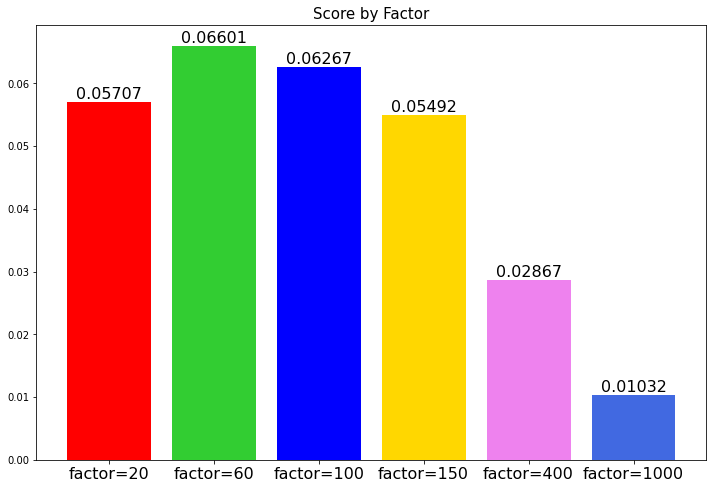

In [131]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
plt.bar(ev_col, ev_score,color = ['r','limegreen','b','gold','violet','royalblue'])
plt.title('Score by Factor',fontsize=(15))
ax.set_xticklabels(ev_col,fontsize=16)
for i, v in enumerate(ev_col):
    plt.text(v, ev_score[i], ev_score[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 16, 
             color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()


결과값을 보면 factor가 증가할 수록 값이 작아지며  
factor = 60 일때, 가장 높은 값을 가졌다.

---
### 8-7 iteration 변경해보기 / iterations = 5
---

위에서 값이 가장 높은 factor = 60을 기준으로  
iterations 변경을 통해 가장 이상적인 값을 찾아보겠다.

In [132]:
als_model_it = AlternatingLeastSquares(factors=60, regularization=0.01, use_gpu=False, iterations=5, dtype=np.float32)
# 모델 훈련
als_model_it.fit(csr_data_transpose)

  0%|          | 0/5 [00:00<?, ?it/s]

In [133]:
print('='*15,'prediction_score','='*15)
print('predeiction_score_top gun:' , prediction_score('top gun (1986)',als_model_it))
print('predeiction_score_back to the fture:', prediction_score('back to the future (1985)',als_model_it),'\n')
print('='*15,'similar_movie','='*15)
get_similar_movie('top gun (1986)',als_model_it)

=============== prediction_score ===============
predeiction_score_top gun: 0.2020389
predeiction_score_back to the fture: 0.32174549 

=============== similar_movie ===============


['romancing the stone (1984)',
 'indiana jones and the temple of doom (1984)',
 'first blood (1982)',
 'dirty dancing (1987)',
 'jewel of the nile, the (1985)',
 'batman (1989)',
 'red dawn (1984)',
 'lethal weapon 2 (1989)',
 'indiana jones and the last crusade (1989)']

In [134]:
recommended_list(als_model_it)

["schindler's list (1993)",
 'saving private ryan (1998)',
 'braveheart (1995)',
 'jurassic park (1993)',
 'princess bride, the (1987)',
 'e.t. the extra-terrestrial (1982)',
 'casablanca (1942)',
 'terminator 2: judgment day (1991)',
 'silence of the lambs, the (1991)',
 'fargo (1996)',
 'star wars: episode vi - return of the jedi (1983)',
 'star wars: episode v - the empire strikes back (1980)',
 'forrest gump (1994)',
 'shakespeare in love (1998)',
 'matrix, the (1999)',
 'star wars: episode iv - a new hope (1977)',
 'toy story (1995)',
 'wizard of oz, the (1939)',
 'american beauty (1999)',
 'rain man (1988)']

In [135]:
evaluation_index(als_model_it)

0.06112

기존 factor = 60 / iterations = 15의 값은 0.06601 이었다.  
현재 iterations의 값만 줄인 결과 수치가 약간 감소하는 것을 확인 할 수 있다.

---
### 8-8  iterations = 30
---

In [136]:
als_model_it2 = AlternatingLeastSquares(factors=60, regularization=0.01, use_gpu=False, iterations=30, dtype=np.float32)
# 모델 훈련
als_model_it2.fit(csr_data_transpose)

  0%|          | 0/30 [00:00<?, ?it/s]

In [137]:
print('='*15,'prediction_score','='*15)
print('predeiction_score_top gun:' , prediction_score('top gun (1986)',als_model_it2))
print('predeiction_score_back to the fture:', prediction_score('back to the future (1985)',als_model_it2),'\n')
print('='*15,'similar_movie','='*15)
get_similar_movie('top gun (1986)',als_model_it2)

=============== prediction_score ===============
predeiction_score_top gun: 0.20414504
predeiction_score_back to the fture: 0.38649178 

=============== similar_movie ===============


['romancing the stone (1984)',
 'indiana jones and the temple of doom (1984)',
 'dirty dancing (1987)',
 'jewel of the nile, the (1985)',
 'first blood (1982)',
 'pretty in pink (1986)',
 'grease (1978)',
 'red dawn (1984)',
 'flashdance (1983)']

In [138]:
recommended_list(als_model_it2)

['casablanca (1942)',
 'star wars: episode vi - return of the jedi (1983)',
 'star wars: episode v - the empire strikes back (1980)',
 "schindler's list (1993)",
 'e.t. the extra-terrestrial (1982)',
 'saving private ryan (1998)',
 'star wars: episode iv - a new hope (1977)',
 'forrest gump (1994)',
 'braveheart (1995)',
 'princess bride, the (1987)',
 'silence of the lambs, the (1991)',
 'raiders of the lost ark (1981)',
 'american beauty (1999)',
 'jurassic park (1993)',
 'wizard of oz, the (1939)',
 'matrix, the (1999)',
 'graduate, the (1967)',
 'fargo (1996)',
 'terminator 2: judgment day (1991)',
 'toy story (1995)']

In [139]:
evaluation_index(als_model_it2)

0.06529

초기값과 비슷하나 약간 감소한 값을 가지고 있다.

---
### 8-9  iterations = 100
---

In [140]:
als_model_it3 = AlternatingLeastSquares(factors=60, regularization=0.01, use_gpu=False, iterations=100, dtype=np.float32)
# 모델 훈련
als_model_it3.fit(csr_data_transpose)

  0%|          | 0/100 [00:00<?, ?it/s]

In [141]:
print('='*15,'prediction_score','='*15)
print('predeiction_score_top gun:' , prediction_score('top gun (1986)',als_model_it3))
print('predeiction_score_back to the fture:', prediction_score('back to the future (1985)',als_model_it3),'\n')
print('='*15,'similar_movie','='*15)
get_similar_movie('top gun (1986)',als_model_it3)

=============== prediction_score ===============
predeiction_score_top gun: 0.19216858
predeiction_score_back to the fture: 0.41698313 

=============== similar_movie ===============


['romancing the stone (1984)',
 'indiana jones and the temple of doom (1984)',
 'dirty dancing (1987)',
 'jewel of the nile, the (1985)',
 'first blood (1982)',
 'speed (1994)',
 'for your eyes only (1981)',
 'flashdance (1983)',
 'peggy sue got married (1986)']

In [142]:
recommended_list(als_model_it3)

['e.t. the extra-terrestrial (1982)',
 "schindler's list (1993)",
 'forrest gump (1994)',
 'star wars: episode vi - return of the jedi (1983)',
 'saving private ryan (1998)',
 'casablanca (1942)',
 'star wars: episode v - the empire strikes back (1980)',
 'braveheart (1995)',
 'jurassic park (1993)',
 'star wars: episode iv - a new hope (1977)',
 'silence of the lambs, the (1991)',
 'american beauty (1999)',
 'star wars: episode i - the phantom menace (1999)',
 'terminator 2: judgment day (1991)',
 'toy story (1995)',
 "one flew over the cuckoo's nest (1975)",
 'shakespeare in love (1998)',
 'matrix, the (1999)',
 'toy story 2 (1999)',
 'groundhog day (1993)']

In [143]:
evaluation_index(als_model_it3)

0.06554

iterations = 30일 때 보다 약간 증가하였다.  
iterations의 값을 약간 늘려서 수치의 변화를 확인해 보겠다.

---
### 8-10  iterations = 150
---

In [144]:
als_model_it4 = AlternatingLeastSquares(factors=60, regularization=0.01, use_gpu=False, iterations=150, dtype=np.float32)
# 모델 훈련
als_model_it4.fit(csr_data_transpose)

  0%|          | 0/150 [00:00<?, ?it/s]

In [145]:
print('='*15,'prediction_score','='*15)
print('predeiction_score_top gun:' , prediction_score('top gun (1986)',als_model_it4))
print('predeiction_score_back to the fture:', prediction_score('back to the future (1985)',als_model_it4),'\n')
print('='*15,'similar_movie','='*15)
get_similar_movie('top gun (1986)',als_model_it4)

=============== prediction_score ===============
predeiction_score_top gun: 0.18029395
predeiction_score_back to the fture: 0.3995411 

=============== similar_movie ===============


['romancing the stone (1984)',
 'indiana jones and the temple of doom (1984)',
 'dirty dancing (1987)',
 'jewel of the nile, the (1985)',
 'speed (1994)',
 'first blood (1982)',
 'red dawn (1984)',
 'for your eyes only (1981)',
 'peggy sue got married (1986)']

In [146]:
recommended_list(als_model_it4)

['e.t. the extra-terrestrial (1982)',
 'casablanca (1942)',
 'star wars: episode vi - return of the jedi (1983)',
 "schindler's list (1993)",
 'saving private ryan (1998)',
 'star wars: episode v - the empire strikes back (1980)',
 'forrest gump (1994)',
 'star wars: episode iv - a new hope (1977)',
 'braveheart (1995)',
 'jurassic park (1993)',
 'silence of the lambs, the (1991)',
 'american beauty (1999)',
 'terminator 2: judgment day (1991)',
 'matrix, the (1999)',
 'princess bride, the (1987)',
 'raiders of the lost ark (1981)',
 'star wars: episode i - the phantom menace (1999)',
 'wizard of oz, the (1939)',
 'toy story (1995)',
 'titanic (1997)']

In [147]:
evaluation_index(als_model_it4)

0.06465

---
### 8-11 iterations 결과값 한 눈에 보기
---

In [148]:
it_score = [evaluation_index(als_model_it),
           evaluation_index(als_model3),
           evaluation_index(als_model_it2),
           evaluation_index(als_model_it3),
           evaluation_index(als_model_it4)]
it_col = ['iterations=5','iterations=15','iterations=30','iterations=100','iterations=150']

/tmp/ipykernel_128/3266026990.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(it_col,fontsize=16)


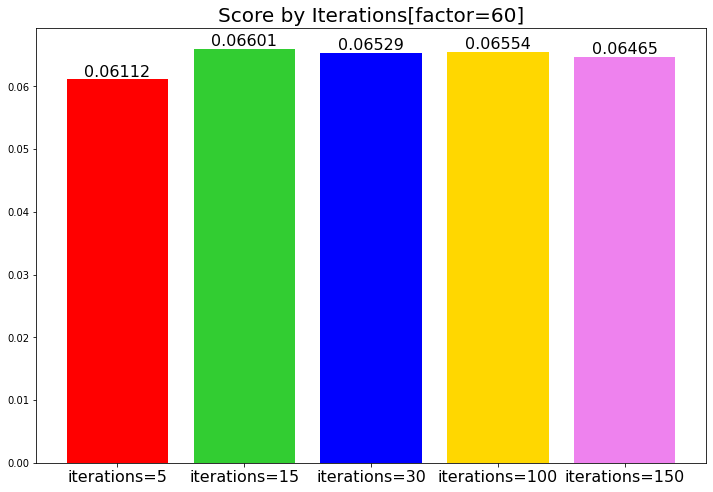

In [151]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
plt.bar(it_col, it_score, color = ['r','limegreen','b','gold','violet'])
plt.title('Score by Iterations[factor=60]',fontsize=(20))
ax.set_xticklabels(it_col,fontsize=16)
for i, v in enumerate(it_col):
    plt.text(v, it_score[i], it_score[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 16, 
             color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()



factor=60 / iterations = 15를 기준으로 삼았을때,  
iterations의 값을 변경해도 점수의 차이는 크게 변경되지 않았다.

---
### 번외. 과적합 조절해보기
---

- 8-6의 factor 결과값을 보면 factor가 클수록 점수가 크게 감소하는 것을 볼 수 있었다.
- factor가 400을 기준값으로 놓고 모델의 하이퍼파라미터인 regularization 변경을 통해 
- 해당 수치값을 변화시킬 수 있는지 테스트 해보겠다.

In [152]:
als_model_re = AlternatingLeastSquares(factors=400, regularization=0.05, use_gpu=False, iterations=15, dtype=np.float32)
# 모델 훈련
als_model_re.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [153]:
evaluation_index(als_model_re)

0.02772

In [154]:
als_model_re2 = AlternatingLeastSquares(factors=400, regularization=0.1, use_gpu=False, iterations=15, dtype=np.float32)
# 모델 훈련
als_model_re2.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [155]:
evaluation_index(als_model_re2)

0.02763

In [156]:
als_model_re3 = AlternatingLeastSquares(factors=400, regularization=0.001, use_gpu=False, iterations=15, dtype=np.float32)
# 모델 훈련
als_model_re3.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [157]:
evaluation_index(als_model_re3)

0.0257

In [165]:
als_model_re4 = AlternatingLeastSquares(factors=400, regularization=10, use_gpu=False, iterations=15, dtype=np.float32)
# 모델 훈련
als_model_re4.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [166]:
evaluation_index(als_model_re4)

0.02559

In [167]:
als_model_re5 = AlternatingLeastSquares(factors=400, regularization=100, use_gpu=False, iterations=15, dtype=np.float32)
# 모델 훈련
als_model_re5.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [168]:
evaluation_index(als_model_re5)

0.03735

In [171]:
als_model_re6 = AlternatingLeastSquares(factors=400, regularization=300, use_gpu=False, iterations=15, dtype=np.float32)
# 모델 훈련
als_model_re6.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [172]:
evaluation_index(als_model_re6)

0.01725

In [173]:
re_score = [evaluation_index(als_model_re3),
           evaluation_index(als_model_re),
           evaluation_index(als_model_re2),
           evaluation_index(als_model_re4),
           evaluation_index(als_model_re5),
           evaluation_index(als_model_re6)]
re_col = ['regularization=0.001','regularization=0.05','regularization=0.1',
          'regularization=10','regularization=100','regularization=300']

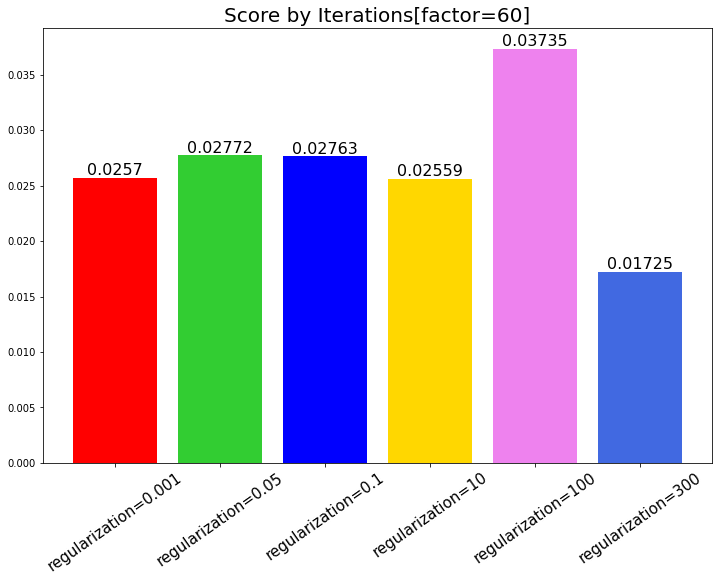

In [185]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
plt.bar(re_col, re_score, color = ['r','limegreen','b','gold','violet','royalblue'])
plt.title('Score by Iterations[factor=60]',fontsize=(20))
plt.xticks(rotation=35,fontsize=15)
for i, v in enumerate(re_col):
    plt.text(v, re_score[i], re_score[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 16, 
             color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()




regularization의 값을 더 작게 하거나 약간만 크게 하였을 때에는 결과값의 변동이 적었다.  
다만, 해당 값을 100단위로 키웠을 때, 결과값에 큰 변동이 있을음 확인할 수 있었다.  
나의 생각에는 regularization이 소수점 단위로 움직이는 것이 바람직하다고 생각하였으나,
이번에는 생각과 반대의 결과가 나왔다.  
regularization의 수학적 공식에 대한 정보가 부족해 왜 값이 100단위로 커졌을 때, 변동이 있는지 이해는 하지 못하였다.

---
# 9.회고
---

- 모델의 하이퍼파라미터값을 변경해본 결과 가장 큰 영향을 미치는 것은  
  유저와 아이템의 백터 차원의 수인 factor값이 가장 영향이 있음을 알 수 있었다. <br><br>
- 처음 코드를 따라하기에는 간단한것 처럼 느껴졌으나, 실제로 코드와 큰 틀을 이해하는 과정에서 어려움을 느꼈다.<br><br>
- 하이퍼파라미터 값을 변경함에 있어서 기준점을 가지는 것이 중요한데,  
  이번 같은 경우에는 명확한 수치값이 주어진 것이 없어 기준을 잡는 것에 있어서 다소 헷갈렸다.<br><br>
- 물론 MAP / Precision / Recall과 같은 값을 기준으로 할 수 있으나,  
  해당 값을 어떠한 방식으로 도출해야 하는지에 대해 어려움을 느꼈다.<br><br>
- 그 결과 추천시스템의 정확성을 따지는 지표는 나의 생각대로 기준을 잡아서 여러가지 시도를 진행하였다.<br><br>
- 위 7번 파트에서 적었듯이, 좋아하는 영화 5가지의 값을 기준으로 추천해주는 영화와의 유사도 평균값을 기준으로 삼았다.<br><br>
- 임의로 설정한 기준 값을 토대로 값의 변화를 찾은 것이기에 실제와의 괴리는 충분히 있을 수 있다고 생각이 든다.<br><br>
- implicit의 버전 오류로 인해 colab에서 돌릴땐, 헷갈릴 수 있는 요소들이 다분했다. <br><br>
- 미리 원인을 찾고 공유해준 인원 덕분에 헤매는 시간을 줄일 수 있었다.<br><br>
- 다만, 사전에 학습페이지에서 공지를 해주면 더 좋았을 것이라는 생각이 든다.<br><br>